In [1]:
# External libraries
import numpy as np
import os
from pydrake.common import temp_directory

# Drake dependencies
from pydrake.all import (
    DiagramBuilder,
    Simulator,
    AddDefaultVisualization,
    StartMeshcat,
    RigidTransform,
    RollPitchYaw,
    RotationMatrix,
    Parser,
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    Parser,
    Simulator,
    StartMeshcat,
    LoadModelDirectivesFromString,
    ProcessModelDirectives,
    DiscreteContactApproximation,
    RgbdSensor,
    DepthImageToPointCloud,
    CameraInfo,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
)

import manipulation
from manipulation.meshcat_utils import MeshcatSliders, StopButton
from manipulation.utils import RenderDiagram, ConfigureParser
from manipulation.scenarios import AddMultibodyTriad
from manipulation.scenarios import AddRgbdSensors
from manipulation.clutter import GraspCandidateCost, GenerateAntipodalGraspCandidate

from ShishKebot.Perception import ProcessPointCloud
from ShishKebot.Planning import CandidateGrasp

meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7002


In [2]:
# Create a Drake temporary directory to store files.
# Note: this tutorial will create a temporary file (table_top.sdf)
# in the `/tmp/robotlocomotion_drake_xxxxxx` directory.
temp_dir = temp_directory()

# Create a table top SDFormat model.
table_top_sdf_file = os.path.join(temp_dir, "table_top.sdf")
table_top_sdf = """<?xml version="1.0"?>
<sdf version="1.7">

  <model name="table_top">
    <link name="table_top_link">
      <inertial>
        <mass>18.70</mass>
        <inertia>
          <ixx>0.79</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.53</iyy>
          <iyz>0</iyz>
          <izz>1.2</izz>
        </inertia>
      </inertial>
    <visual name="bottom">
        <pose>0.0 0.0 0.445 0 0 0</pose>
        <geometry>
          <box>
            <size>10 10 0.015</size>
          </box>
        </geometry>
        <material>
          <diffuse>0.9 0.9 0.9 1.0</diffuse>
        </material>
      </visual>
      <collision name="bottom">
        <pose>0.0 0.0 0.445 0 0 0</pose>
        <geometry>
          <box>
            <size>10 10 0.015</size>
          </box>
        </geometry>
        <drake:proximity_properties>
          <drake:compliant_hydroelastic/>
          <drake:hydroelastic_modulus>1.0e6</drake:hydroelastic_modulus>
        </drake:proximity_properties>
      </collision>
    </link>
    <frame name="table_top_center">
      <pose relative_to="table_top_link">0 0 0.47 0 0 0</pose>
    </frame>
  </model>
</sdf>

"""

with open(table_top_sdf_file, "w") as f:
    f.write(table_top_sdf)

In [3]:
model_directive = f"""
directives:
- add_model:
    name: food
    file: file://{os.getcwd()}/Models/cube_food.sdf
    default_free_body_pose:
        cube_food:
            translation: [0, 0, 0.05]
- add_model:
    name: table
    file: file://{table_top_sdf_file}
- add_weld:
    parent: world
    child: table::table_top_center

- add_frame:
    name: camera0_origin
    X_PF:
        base_frame: world
        rotation: !Rpy {{ deg: [225, 0, 90]}}
        translation: [0.5, 0, 0.5]
- add_model:
    name: camera0
    file: package://manipulation/camera_box.sdf
- add_weld:
    parent: camera0_origin
    child: camera0::base

- add_model:
    name: wsg
    file: package://manipulation/schunk_wsg_50_welded_fingers.sdf
    default_free_body_pose:
        body:
            translation: [0, 0, 10000]

- add_frame:
    name: camera1_origin
    X_PF:
        base_frame: world
        rotation: !Rpy {{ deg: [225, 0, -90]}}
        translation: [-0.5, 0, 0.5]
- add_model:
    name: camera1
    file: package://manipulation/camera_box.sdf
- add_weld:
    parent: camera1_origin
    child: camera1::base
"""

In [4]:
builder = DiagramBuilder()

plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-3)
plant.set_discrete_contact_approximation(DiscreteContactApproximation.kSap)
directives = LoadModelDirectivesFromString(model_directive)
parser = Parser(plant)
parser.package_map().Add("manipulation", manipulation.__path__[0] + "/models/")
models = ProcessModelDirectives(directives, plant, parser)
plant.Finalize()

AddRgbdSensors(builder, plant, scene_graph)

# Connect meshcat to scene
AddDefaultVisualization(builder, meshcat)
diagram = builder.Build()
simulator = Simulator(diagram)

In [5]:
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(context)
point_cloud1 = diagram.GetOutputPort("camera{}_point_cloud".format(0)).Eval(context)
point_cloud2 = diagram.GetOutputPort("camera{}_point_cloud".format(1)).Eval(context)

processed = ProcessPointCloud([point_cloud1, point_cloud2], plant, plant_context, remove_plane=True)
meshcat.SetObject(f"point cloud", processed)

In [6]:
def draw_grasp_candidate(X_G, prefix="gripper", draw_frames=True, refresh=False):
    if refresh:
        meshcat.Delete()
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    parser = Parser(plant)
    ConfigureParser(parser)
    gripper = parser.AddModelsFromUrl(
        "package://manipulation/schunk_wsg_50_welded_fingers.sdf"
    )
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("body"), X_G)
    if draw_frames:
        AddMultibodyTriad(plant.GetFrameByName("body"), scene_graph)
    plant.Finalize()

    params = MeshcatVisualizerParams()
    params.prefix = prefix
    meshcat_vis = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, params)
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.ForcedPublish(context)
    

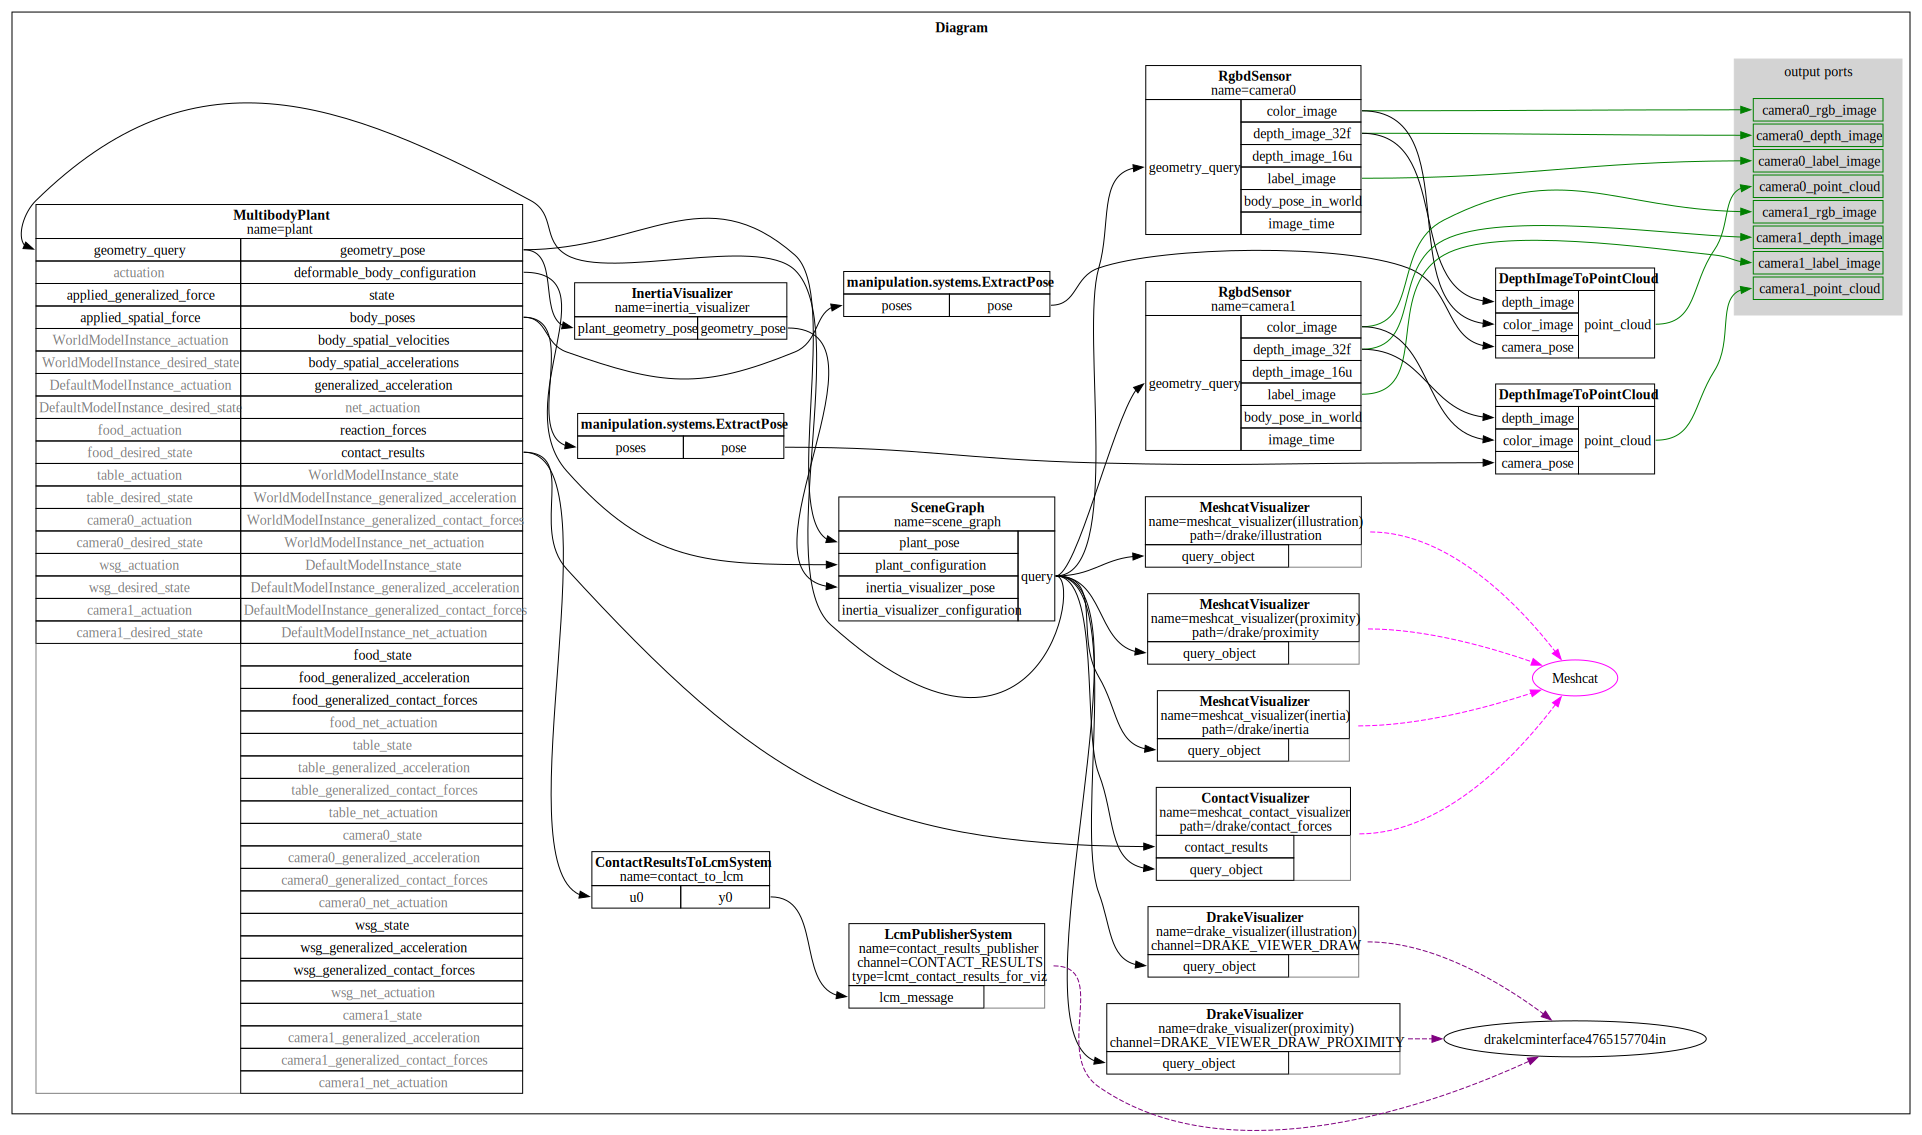

In [7]:
from manipulation.utils import RenderDiagram
RenderDiagram(diagram)

In [8]:
min_cost = np.inf
for i in range(100):
        cost, X_G = GenerateAntipodalGraspCandidate(
            diagram, context, processed, rng=np.random.default_rng()
        )
        if np.isfinite(cost) and cost < min_cost:
            min_cost = cost
            best_X_G = X_G
print(best_X_G)

RigidTransform(
  R=RotationMatrix([
    [0.9999998694061049, -0.0005110641371485175, -1.1049497453497837e-06],
    [1.1048828595081918e-06, -1.3115796428573848e-07, 0.9999999999993809],
    [-0.0005110641372931241, -0.9999998694067067, -1.305932811520643e-07],
  ]),
  p=[-0.036525813470119274, -0.0324902561304819, 0.21922220919914495],
)


In [9]:

X_G = CandidateGrasp(processed, max_iter = 100)
draw_grasp_candidate(X_G)

In [10]:

meshcat.StartRecording(set_visualizations_while_recording=False)
simulator.AdvanceTo(4)
meshcat.PublishRecording()
